In [94]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
from pandas_profiling import ProfileReport
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
!pip install mlxtend
from mlxtend.plotting import plot_decision_regions
!pip install imbalanced-learn
!pip install scikit-learn
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
!pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
!pip install -r requirements.txt | grep -v 'already satisfied'
!pip install --user --upgrade tensorflow
!pip install --user --upgrade tensorboard
!pip install keras==2.3.1
!pip install --user --upgrade tensorflow==1.14.0
from keras import layers, models, optimizers, losses, metrics
import tensorflow as tf

'grep' is not recognized as an internal or external command,
operable program or batch file.


  Using cached tensorflow-2.4.0-cp37-cp37m-win_amd64.whl (370.7 MB)
  Using cached tensorboard-2.4.0-py3-none-any.whl (10.6 MB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0
  Rolling back uninstall of tensorflow
  Moving to c:\users\ualbertin\appdata\roaming\python\python37\scripts\freeze_graph.exe
   from C:\Users\UALBER~1\AppData\Local\Temp\pip-uninstall-oa8_1pnp\freeze_graph.exe
  Moving to c:\users\ualbertin\

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an EnvironmentError: [Errno 28] No space left on device



Requirement already up-to-date: tensorboard in c:\users\ualbertin\appdata\roaming\python\python37\site-packages (2.4.0)
Requirement already up-to-date: tensorflow==1.14.0 in c:\users\ualbertin\appdata\roaming\python\python37\site-packages (1.14.0)
  Using cached tensorboard-1.14.0-py3-none-any.whl (3.1 MB)
  Using cached tensorflow_estimator-1.14.0-py2.py3-none-any.whl (488 kB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# The following is an analysis of time-series data. The first part of the analysis examines data from simulated logins from an unspecified geographic location. Exploratory data analysis follows below. Part 1:

In [2]:
#Load the data and aggregate into 15 minute intervals, creating a count column
path='C://Users//ualbertin//Documents//Springboard//UltimateDataChallenge'
os.chdir(path)
df = pd.read_json('logins.json')
df=df.set_index('login_time')
df['counts']=0
df=df.resample('15Min').count() #resample to 15 minute intervals
df=df.reset_index()
df.head()

login_time  counts
0 1970-01-01 20:00:00       2
1 1970-01-01 20:15:00       6
2 1970-01-01 20:30:00       9
3 1970-01-01 20:45:00       7
4 1970-01-01 21:00:00       1

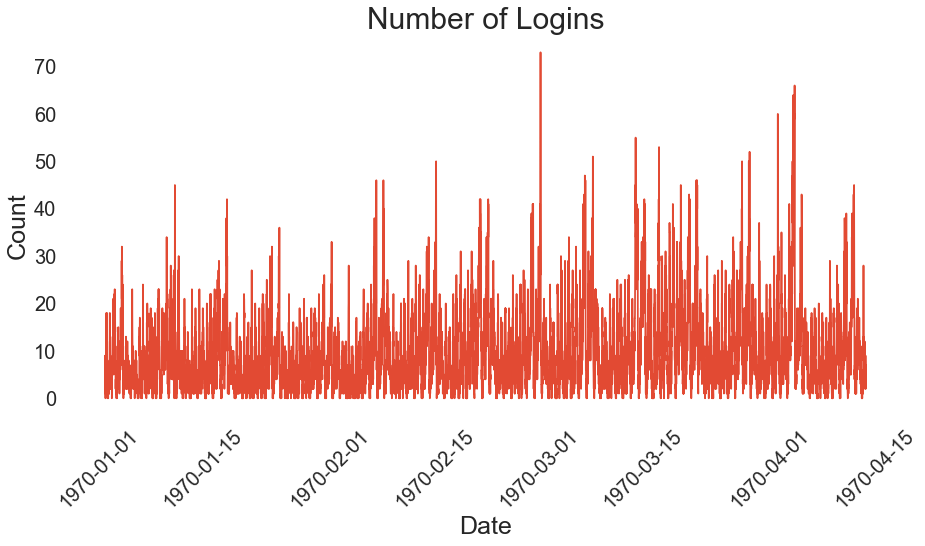

In [3]:
fig = plt.figure(figsize=(15,7))
ax = plt.axes()
sns.lineplot(df.login_time,df['counts'])
ax.set_xlabel('Date',fontsize=25)
ax.set_ylabel('Count',fontsize=25)
plt.title('Number of Logins',fontsize=30)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## The majority of the logins occured between 10 pm and 2 am and at lunch time:

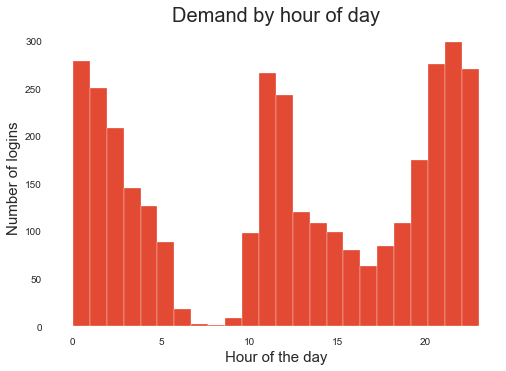

In [4]:
plt.hist(df.loc[df.counts>10].login_time.dt.hour,bins=24)
plt.xlabel('Hour of the day',fontsize=15)
plt.ylabel('Number of logins', fontsize=15)
plt.title('Demand by hour of day', fontsize=20)
plt.show()

## The login times have periodicity:

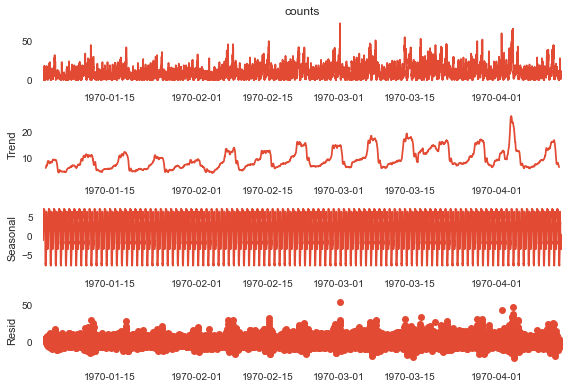

In [5]:
df.set_index('login_time',inplace=True)
result = seasonal_decompose(df['counts'],freq=96)
# Plot the original data, the trend, the seasonality, and the residuals 
result.plot()
plt.show()

## Certain hourly intervals are more frequent than others:

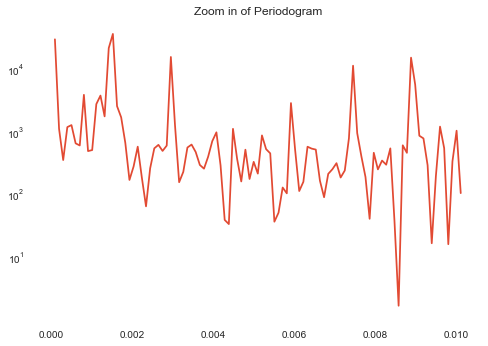

In [6]:
f, P = signal.periodogram(df['counts'])
plt.semilogy(f[1:100],P[1:100]) #neglecting DC
plt.title('Zoom in of Periodogram')
plt.show()

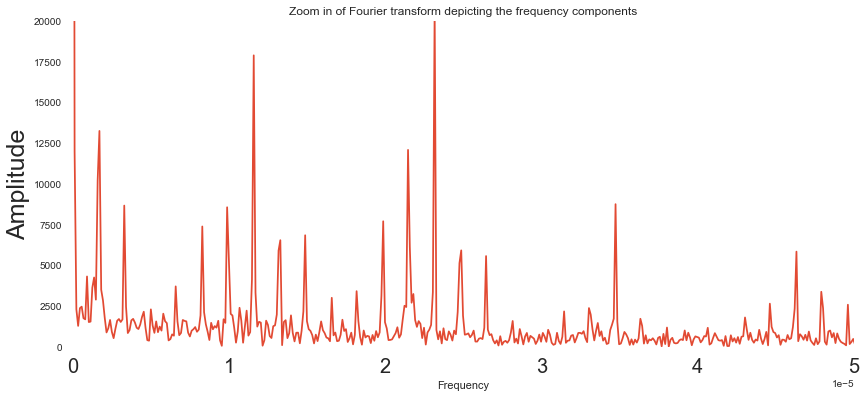

In [7]:
import numpy as np
fig, axes = plt.subplots(figsize=(14, 6))
ft_ = np.fft.fft(df['counts'])  # Normalize amplitude and apply the FFT
ft_ = ft_[range(int(len(df['counts'])/2))]   # Exclude sampling frequency
tp_cnt = len(df['counts'])
val_ = np.arange(int(tp_cnt / 2))
tm_period_ = tp_cnt / (1/900)
tm_period = 900
freq_ = val_ / tm_period_
axes.set_title('Zoom in of Fourier transform depicting the frequency components')
axes.plot(freq_, abs(ft_))
axes.set_xlabel('Frequency')
axes.set_ylabel('Amplitude',fontsize=25)
axes.set_xlim([0,0.00005])
axes.set_ylim([0,20000])
plt.xticks(fontsize=20)
plt.show()

## There are cycles of demand occuring every 12 hours, daily, and every 6.8 days:

In [8]:
delta_f=1/(9788*900) #frequency steps
(1/(np.where(abs(ft_)>12500)[0]*delta_f))/60/60/24 #number of days where signal repeats

array([       inf, 6.79722222, 0.9995915 , 0.49979575])

## Smaller demand cycles also occur every 102 days and at the following hour intervals:

In [9]:
(1/(np.where((abs(ft_)>7500) & (abs(ft_)<12500))[0]*delta_f))/60/60

array([2447.        ,  174.78571429,   84.37931034,   28.12643678,
         13.98285714,   12.94708995,    7.99673203])

## Part 2 ‑ Experiment and metrics design:  The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.  
### 1.) What   would   you   choose   as   the   key   measure   of   success   of   this   experiment in  encouraging   driver   partners   to   serve   both   cities, and why would you choose this   metric?  
### -> A key measure would be the number of reimbursed tolls. An increase in this number would mean that drivers are crossing the toll bridge to be available in the other city.  
### 2. Describe   a   practical   experiment   you   would   design   to   compare   the   effectiveness   of   the  proposed   change   in   relation   to   the   key   measure   of   success.   Please   provide   details   on:   
### a. how   you   will   implement   the   experiment  
### -> In order to compare the effectiveness of the experiment, an A/B test could be conducted where in A, the number of tolls prior to a toll reimbursement scheme along with the user that paid them are counted over a period of time. B would take place after the proposed change to reimburse tolls took place and would count the number of tolls over a similar period of time. 
### b. what   statistical   test(s)   you   will   conduct   to   verify   the   significance   of   the  observation  
### -->A statistical test may evaluate the null hypothesis that the drivers did not cross the toll bridge more frequently after the toll reimbursement scheme was implemented. A test for statistical significance should be appropriately chosen depending on the distribution of the toll charges before and after the program takes effect. A toll is a transactional purchase and is likely to have a Poisson distribution, in which case, an E-test would be appropriate.
### c. how   you   would   interpret   the   results   and   provide   recommendations   to   the   city  operations   team   along   with   any   caveats. 
### -> I would interpret the results using user_id in addition to the number of tolls to determine if additional tolls were being changed by drivers for Ultimate or other recreational drivers. If there is an increase in tolls among Ultimate drivers, I would further examine trends among those drivers to isolate features that correlated with increased tolls. If such features are readily apparent such as type of phone, login_city, etc., I would recommend strategies that would bolster the adaptation or use of these features.

In [10]:
9788/2

4894.0

## Part   3   ‑   Predictive modeling for rider   retention to   help   understand   what   factors   are   the   best   predictors  for   retention,   with  suggestions   to   operationalize   those   insights   to   help   Ultimate.       

## Load the new data and assign a new variable to evaluate active users:

In [52]:
df2 = pd.read_json('ultimate_data_challenge.json')
df2['signup_date']=pd.to_datetime(df2['signup_date']) #change types to datetime
df2['last_trip_date']=pd.to_datetime(df2['last_trip_date'])
df2['active_user'] = (pd.to_datetime('2014-07-01') - df2['last_trip_date']) < '30 days'
df2.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  active_user  
0         46.2      3.67                   5.0         True  
1         50.0      8.26                   5.0        False  
2        100.0      0.77                   5.0        False  
3         80.0      2.36                   4.9         True  
4         82.4      3.13                   4.9        False

## Ensure that the variables are appropriately typed:

In [53]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  active_user             50000 non-null  bool  

In [54]:
df2.describe()

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            50000.000000          41878.000000  50000.000000   
mean                 2.278200              4.601559      1.074764   
std                  3.792684              0.617338      0.222336   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.300000      1.000000   
50%                  1.000000              4.900000      1.000000   
75%                  3.000000              5.000000      1.050000   
max                125.000000              5.000000      8.000000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  50000.000000  50000.000000  50000.000000          49799.000000  
mean       8.849536     60.926084      5.796827              4.778158  
std       19.958811     37.081503      5.707357              0.446652  
min        0.000000      0.000000      0.000000              1.000000  
25%        0.000000     33.300000      2.420000              4.700000  
50%        0.000000     66.700000      3.880000              5.000000  
75%        8.600000    100.000000      6.940000              5.000000  
max      100.000000    100.000000    160.960000              5.000000

## Pandas profiling shows that:
### 1) the dependent variable active_user is positively correlated with phone, surge_pct, ultimate_black_user, weekday_pct, and negatively correlated with avg_rating_by_driver and avg_rating_of_driver
### 2) that there are missing values in avg_rating_of_driver, phone and avg_rating_by_driver and 

### 3) almost all of the variables have skewed or binomial distributions.
### 4) 36.6% of the users were retained.

In [44]:
profile=ProfileReport(df2)
profile.to_notebook_iframe()

## Fill in missing values for both driver ratings using mean values, and for phone with 'Unknown':

In [56]:
df2.avg_rating_of_driver=df2.avg_rating_of_driver.fillna(value=df2.avg_rating_of_driver.mean())
df2.avg_rating_by_driver=df2.avg_rating_by_driver.fillna(value=df2.avg_rating_by_driver.mean())
df2.phone=df2.phone.fillna(value='Unknown')

## Encode the two categorical variables: city and phone

In [57]:
df2 = pd.get_dummies(df2, drop_first=True)
df2.head()

trips_in_first_30_days signup_date  avg_rating_of_driver  avg_surge  \
0                       4  2014-01-25                   4.7       1.10   
1                       0  2014-01-29                   5.0       1.00   
2                       3  2014-01-06                   4.3       1.00   
3                       9  2014-01-10                   4.6       1.14   
4                      14  2014-01-27                   4.4       1.19   

  last_trip_date  surge_pct  ultimate_black_user  weekday_pct  avg_dist  \
0     2014-06-17       15.4                 True         46.2      3.67   
1     2014-05-05        0.0                False         50.0      8.26   
2     2014-01-07        0.0                False        100.0      0.77   
3     2014-06-29       20.0                 True         80.0      2.36   
4     2014-03-15       11.8                False         82.4      3.13   

   avg_rating_by_driver  active_user  city_King's Landing  city_Winterfell  \
0                   5.0         True                    1                0   
1                   5.0        False                    0                0   
2                   5.0        False                    0                0   
3                   4.9         True                    1                0   
4                   4.9        False                    0                1   

   phone_Unknown  phone_iPhone  
0              0             1  
1              0             0  
2              0             1  
3              0             1  
4              0             0

## Split into dependent and independent variables, test and training sets.

In [18]:
y = df2['active_user'] #dependent variable
X = df2.drop(['active_user','signup_date','last_trip_date'],axis=1) #independent variables
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train) #Fit scaler on training data
X_test = scaler.transform(X_test) #Apply scaler to test data

## In order to determine feature importance, model variables using logistic regression for binary classification, which returns weights for interpretability.

### The accuracy score on the test & training set do not vary signficantly, indicating that overfitting is not an issue.

In [19]:
lr=LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
print('Test score: ', lr.score(X_test,y_test))
print('Training score:', lr.score(X_train,y_train))

Test score:  0.7243
Training score: 0.7256


## The most important features towards user retention are 
### 1) if the user signed up in the city of King's Landing, <p>
### 2) that they use an iPhone, <p>
### 3) they had a large number of trips in the first 30 days, <p>
### 4) and that they took an Ultimate Black. <p>

### Poor driving experience (rating by either user or driver) and small distances were negatively correlated with retention.

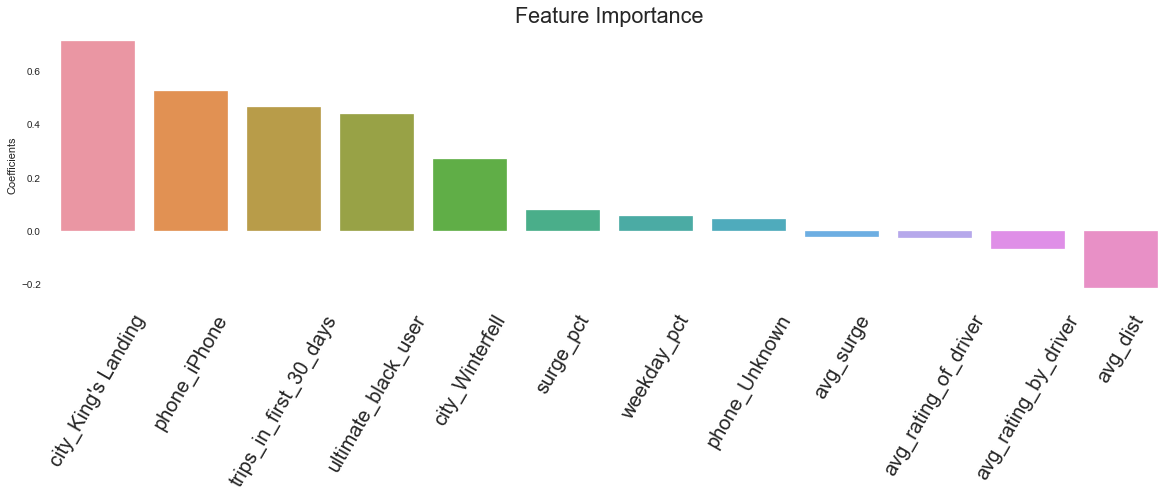

In [20]:
lr_results=pd.DataFrame()
lr_results['Features'] = X.columns
lr_results['Coefficients'] = (lr.coef_.tolist()[0])
lr_results = lr_results.sort_values(by='Coefficients', ascending=False)
fig, ax = plt.subplots(figsize=(20,5))
ax=sns.barplot(data=lr_results,x='Features',y='Coefficients')
sns.set(font_scale=1.8)
plt.title('Feature Importance')
ax.set(xlabel=None)
plt.xticks(rotation=60,fontsize=20)
plt.show()

## Recommended Strategies for boosting long-term driver retention:
### 1) Increase advertising in the cities of Astapor and Winterfell. Data suggests that there is an opportunity to expand into these markets using the same kind of material that resonated with drivers to sign up in King's Landing.
### 2) Look into options to make Ultimate driver apps on non-iPhone platforms more attractive, usable, and/or available.
### 3) Encourage the number of trips in the first 30 days by introducing a rewards program based on frequency of use and driving distance.
### 4) Encourage the adaptation of Ultimate Black either by enhanced rewards, a free trial, or a point system.
### 5) Study the rating system to determine the underlying causes for poor ratings. If appropriate, a) communicate poor ratings by drivers to other drivers by alerting them ahead of time about a customer's rating, b) remind users to be courteous when using Ultimate services, c) disable the use of Ultimate by abusive or riders that engage in unsafe or illegal activities during the ride, and d) encourage training and support for drivers to decrease the number of poorly rated rides by users.
### 6) Increase usage by riders by advertising ride services as means to get to/from work, home safely after drinking, and to use as transportation to/from lunch with coworkers, to capitalize on observed hourly and daily usage trends. An increase in ridership means that drivers have the opportunity to earn more wages through driving.

# Part 3 (continued): Build   a   predictive   model   to   help   Ultimate   determine   whether   or   not   a   user   will   be   active  in   their   6th   month   on   the   system.   

### There are only 13 users out of 50,000 that have been active for their 6th month on the system. This is a very undersampled minority dataset. Even after the application of oversampling techniques, any conclusions drawn from this small of a sample may likely not transfer to a general population.

In [22]:
df2['active_user_6m'] = (df2['last_trip_date'] - df2['signup_date']) > '180 days'
df2.loc[df2.active_user_6m == True].active_user_6m.count()

13

## Split into dependent and independent variables, test and training sets.

In [23]:
y = df2['active_user_6m'] #dependent variable
X = df2.drop(['active_user','active_user_6m','signup_date','last_trip_date'],axis=1) #independent variables
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train) #Fit scaler on training data
X_test = scaler.transform(X_test) #Apply scaler to test data

### Looking at the confusion matrix for KNN confirms that undersampling is an issue. Just by classifying all entries as negatives, it achieves a very high accuracy rate:

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print('Test score: ', knn.score(X_test,y_test))
print('Training score:', knn.score(X_train,y_train))
print(f'Test Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

Test score:  0.9996
Training score: 0.999775
Test Confusion Matrix: 
[[9996    0]
 [   4    0]]


### Oversample using Synthetic Minority Oversampling Technique (SMOTE):

In [27]:
oversample=SMOTE()
X, y = oversample.fit_resample(X,y) #resample dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train) #Fit scaler on training data
X_test = scaler.transform(X_test) #Apply scaler to test data

### Now KNN doesn't automatically classify into negatives:

In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print('Test score: ', knn.score(X_test,y_test))
print('Training score:', knn.score(X_train,y_train))
print(f'Test Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

Test score:  0.994748687171793
Training score: 0.9959989497243026
Test Confusion Matrix: 
[[10002   105]
 [    0  9888]]


### Random forest with a depth of 8 performs equaliy well on train and test data, suggesting that it's not overfitting (a common problem), but misclassifies more false negatives than knn:

In [32]:
rf = RandomForestClassifier(n_estimators=30, max_depth=8)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
print('Test score: ', rf.score(X_test,y_test))
print('Training score:', rf.score(X_train,y_train))
print(f'Test Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

Test score:  0.9870967741935484
Training score: 0.9874091949136649
Test Confusion Matrix: 
[[9851  256]
 [   2 9886]]


## Use a voting classifer to evaluate several other modeling techniques for binary classification including Support Vector Machine, Bagging Decision Tree, and the previous KNN and Random Forest algorithms, shows that the previous KNN misclassifies the least number of users, but that it's likely because of overfitting.

In [36]:
nb = MultinomialNB()
svm=LinearSVC(C=0.0001)
bg=BaggingClassifier(max_samples=0.5, max_features=1,n_estimators=100)
evc=VotingClassifier(estimators=[('knn',knn),('lr',lr),('rf',rf),
                                 ('svm',svm),('bg',bg)],voting='hard')
evc.fit(X_train,y_train)
y_pred=evc.predict(X_test)
print('Test score: ', evc.score(X_test,y_test))
print('Training score:', evc.score(X_train,y_train))
print(f'Test Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

Test score:  0.986946736684171
Training score: 0.9881969016866927
Test Confusion Matrix: 
[[9853  254]
 [   7 9881]]


## Lastly, a deep learning model provides the best accuracy and least number of misclassifications. The accuracy on both the training and test sets are comparable indicating that the model is not overfitting:

In [89]:
X_validation = X_train[:20000]
X_partial_train=X_train[20000:]
y_validation = y_train[:20000]
y_partial_train = y_train[20000:]
model=models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(12,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(X_partial_train,y_partial_train,epochs=15,batch_size=512,validation_data=(X_validation,y_validation))
print('\ntest: ',str(model.evaluate(X_test,y_test)[1]))
print('\ntrain: ',str(model.evaluate(X_train,y_train)[1]))
y_pred=model.predict_classes(X_test)
cm=tf.math.confusion_matrix(labels=y_test,predictions=y_pred)
with tf.Session() as sess:
    cmp=sess.run(cm)
    print(cmp)

Train on 59979 samples, validate on 20000 samples
Epoch 1/15
59979/59979 [==============================] - 0s 8us/step - loss: 0.4892 - accuracy: 0.8148 - val_loss: 0.3215 - val_accuracy: 0.9046
Epoch 2/15
59979/59979 [==============================] - 0s 4us/step - loss: 0.2374 - accuracy: 0.9196 - val_loss: 0.1763 - val_accuracy: 0.9373
Epoch 3/15
59979/59979 [==============================] - 0s 4us/step - loss: 0.1503 - accuracy: 0.9457 - val_loss: 0.1268 - val_accuracy: 0.9571
Epoch 4/15
59979/59979 [==============================] - 0s 4us/step - loss: 0.1112 - accuracy: 0.9613 - val_loss: 0.0994 - val_accuracy: 0.9689
Epoch 5/15
59979/59979 [==============================] - 0s 4us/step - loss: 0.0874 - accuracy: 0.9714 - val_loss: 0.0777 - val_accuracy: 0.9750
Epoch 6/15
59979/59979 [==============================] - 0s 4us/step - loss: 0.0708 - accuracy: 0.9778 - val_loss: 0.0681 - val_accuracy: 0.9785
Epoch 7/15
59979/59979 [==============================] - 0s 4us/step - lo

## This deep learning model has the best ability of several to predict driver retention after 6 months, with errors being largely composed of false negatives. The model appears to be valid for this particular data, however the sampling suffers from minority undersampling. Collecting more data to refine this modeling will likely reduce error and improve predictability on new data.